# TimeGrad with a GRU noise model 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# GRU-based TimeGrad noise model
class TimeGradGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, seq_length, num_steps):
        super(TimeGradGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.num_steps = num_steps

        # GRU to model the noise
        self.gru = nn.GRU(input_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)
        self.t_embedding = nn.Embedding(num_steps, hidden_dim)

    def forward(self, x_t, t, h):
        t = t.clamp(0, self.num_steps - 1)

        # Embed the time step
        t_embedded = self.t_embedding(t).unsqueeze(1).repeat(1, self.seq_length, 1)
        # Concatenate x_t with time embedding
        x_t_and_t = torch.cat([x_t, t_embedded], dim=-1)
        # Pass through GRU
        out, h = self.gru(x_t_and_t, h)
        # Predict noise
        pred_noise = self.fc(out)
        return pred_noise, h

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.ones(self.num_layers, batch_size, self.hidden_dim)

# Diffusion process with GRU
class DiffusionModelGRU:
    def __init__(self, model, beta_start=0.0001, beta_end=0.02, num_steps=1000, seq_length=10):
        self.model = model
        self.num_steps = num_steps
        self.seq_length = seq_length

        # Linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        
        # Adding a small epsilon to prevent underflow issues
        self.alpha_bar = self.alpha_bar.clamp(min=1e-5)

    def forward_diffusion(self, x_0):
        noise = torch.randn_like(x_0)
        t = torch.randint(0, self.num_steps, (x_0.size(0),)).to(x_0.device)
        print(t.shape)
        alpha_bar_t = self.alpha_bar[t].unsqueeze(1).unsqueeze(2)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, t, noise

    def reverse_diffusion(self, x_t, t, h):
        pred_noise, h = self.model(x_t, t, h)
        alpha_bar_t = self.alpha_bar[t].unsqueeze(1).unsqueeze(2).expand_as(pred_noise)

         # Adding epsilon to the denominator for numerical stability
        eps = 1e-5
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t + eps)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t + eps)
        
        x_0_pred = (x_t - sqrt_one_minus_alpha_bar_t * pred_noise) / sqrt_alpha_bar_t

        # Preventing any extreme values in x_0_pred
        x_0_pred = x_0_pred.clamp(min=-1e5, max=1e5)
        
        return x_0_pred, pred_noise, h

    def p_sample_loop(self, x_shape, device):
        x_t = torch.randn(x_shape).to(device)  # Starting from random noise
        batch_size = x_shape[0]
        h = self.model.init_hidden(batch_size).to(device)
        
        for t in reversed(range(self.num_steps)):
            t_tensor = torch.full((batch_size,), t, dtype=torch.long).to(device)
            x_0_pred, pred_noise, h = self.reverse_diffusion(x_t, t_tensor, h)
            
            # Preventing x_t from blowing up
            x_t = x_0_pred * torch.sqrt(self.alpha_bar[t_tensor].unsqueeze(1).unsqueeze(2)) + \
                  pred_noise * torch.sqrt(1 - self.alpha_bar[t_tensor].unsqueeze(1).unsqueeze(2))
            x_t = x_t.clamp(min=-1e5, max=1e5)
        
        return x_t

In [3]:
import numpy as np

def generate_sine_wave_dataset(num_samples, seq_length, num_features, noise_std=0.1):
    data = []
    for _ in range(num_samples):
        freq = np.random.uniform(0.1, 1.0, size=num_features)
        phase = np.random.uniform(0, 2 * np.pi, size=num_features)
        x = np.array([np.sin(np.linspace(0, 2 * np.pi, seq_length) * f + p) for f, p in zip(freq, phase)]).T
        x += noise_std * np.random.randn(seq_length, num_features)
        data.append(x)
    return torch.tensor(data, dtype=torch.float32)

def generate_linear_trend_dataset(num_samples, seq_length, num_features, noise_std=0.1):
    data = []
    for _ in range(num_samples):
        slope = np.random.uniform(-0.1, 0.1, size=num_features)
        intercept = np.random.uniform(-1, 1, size=num_features)
        x = np.array([slope * t + intercept for t in range(seq_length)]).T
        x += noise_std * np.random.randn(seq_length, num_features)
        data.append(x)
    return torch.tensor(data, dtype=torch.float32)

def generate_seasonal_dataset(num_samples, seq_length, num_features, noise_std=0.1):
    data = []
    for _ in range(num_samples):
        freqs = np.random.uniform(0.05, 0.25, size=(num_features, 2))  # Two frequencies per feature
        phases = np.random.uniform(0, 2 * np.pi, size=(num_features, 2))
        x = np.array([np.sum([np.sin(np.linspace(0, 2 * np.pi, seq_length) * f + p) for f, p in zip(freq, phase)], axis=0)
                      for freq, phase in zip(freqs, phases)]).T
        x += noise_std * np.random.randn(seq_length, num_features)
        data.append(x)
    return torch.tensor(data, dtype=torch.float32)

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Define synthetic dataset
num_samples = 1000
seq_length = 100
num_features = 2
batch_size = 32
num_steps = 1000
num_epochs = 100
learning_rate = 1e-3

# Select a dataset to train on
data = generate_sine_wave_dataset(num_samples, seq_length, num_features)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, diffusion process, optimizer, and loss function
model = TimeGradGRU(input_dim=num_features, hidden_dim=64, num_layers=2,seq_length=seq_length, num_steps=num_steps)
diffusion = DiffusionModelGRU(model, num_steps=num_steps)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x_0 = batch[0].to(device)
        
        # Forward diffusion
        x_t, t, true_noise = diffusion.forward_diffusion(x_0)
        
        # Initialize hidden state
        h = model.init_hidden(x_0.size(0)).to(device)
        
        # Reverse diffusion to predict the noise
        pred_noise, _ = model(x_t, t, h)
        
        # Compute loss
        loss = criterion(pred_noise, true_noise)
        total_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# # Save the model
# torch.save(model.state_dict(), 'timegrad_gru.pth')

NameError: name 'device' is not defined

In [133]:
# Generate new samples using the trained model
generated_samples = diffusion.p_sample_loop(x_shape=(batch_size, seq_length, num_features), device=device)
print(generated_samples.shape)

torch.Size([32, 100, 2])


In [134]:
generated_samples

tensor([[[ 0.0043,  0.1328],
         [-1.4170, -0.1841],
         [ 0.5940,  0.5921],
         ...,
         [ 0.9467,  0.9679],
         [ 2.2144, -0.2647],
         [-1.8420, -1.1730]],

        [[ 0.3357,  0.2338],
         [-2.2758, -1.3225],
         [-1.5632,  0.1071],
         ...,
         [-0.4779,  0.7143],
         [-0.1842,  0.7308],
         [ 1.3593, -2.0296]],

        [[ 0.2651,  0.7486],
         [ 0.6459, -0.1473],
         [-2.0276,  0.6317],
         ...,
         [-0.6045, -0.1330],
         [ 0.2054,  1.0735],
         [ 0.2677,  0.5080]],

        ...,

        [[-0.5505, -0.8388],
         [-0.1022, -0.1618],
         [ 0.8879, -1.0819],
         ...,
         [-0.4457,  0.1006],
         [-0.1180,  1.5376],
         [ 0.5393,  0.4116]],

        [[-0.9070,  0.7526],
         [ 0.3865,  0.0835],
         [ 0.3038,  0.6760],
         ...,
         [ 0.9623, -1.0345],
         [ 1.5967,  2.5370],
         [-0.3244,  1.1210]],

        [[-0.2794, -0.7060],
       

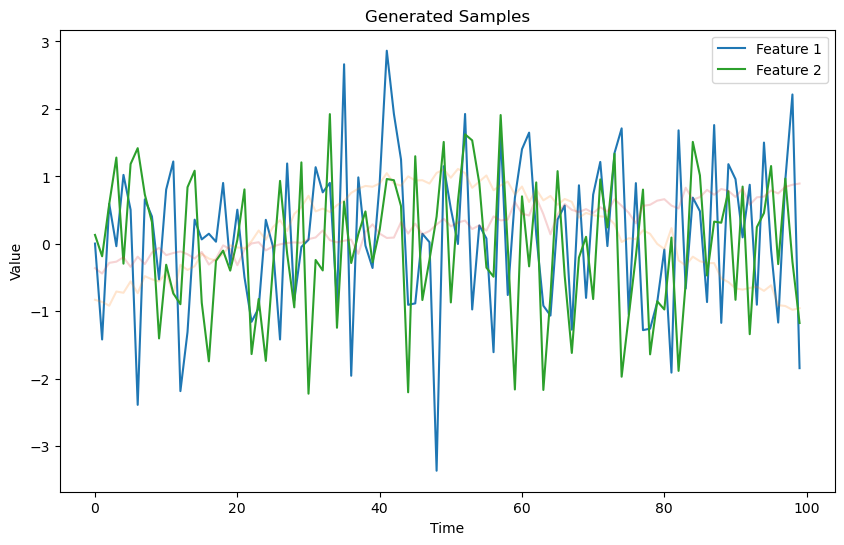

In [138]:
import matplotlib.pyplot as plt

# Plotting generated samples
def plot_samples(samples, title="Generated Samples"):
    plt.figure(figsize=(10, 6))
    for i in range(samples.size(-1)):
        plt.plot(samples[0, :, i].detach().cpu().numpy(), label=f"Feature {i+1}")
        plt.plot(data[0, :, i].numpy(), alpha=0.2)  # Alpha for transparency
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Plot the generated samples
plot_samples(generated_samples)

# TimeGrad implementation with a transformer

In [211]:
import math

class TransformerNoiseModel(nn.Module):
    def __init__(self, num_features, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerNoiseModel, self).__init__()
        
        self.embedding = nn.Linear(num_features + 1, d_model)  # +1 for time embedding
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        self.output_layer = nn.Linear(d_model, num_features)

    def forward(self, x, t):
        # x: [batch_size, seq_length, num_features]
        # t: [batch_size] (time steps)

        # Reshape and expand the time tensor
        # t = t.view(-1, 1, 1)  # Shape: [batch_size, 1, 1]
        # t = t.expand(-1, x.size(1), 1)  # Expand to: [batch_size, seq_length, 1]

        
        # Append time information to x
        x_and_t = torch.cat([x, t], dim=-1)

        # Embedding
        x = self.embedding(x_and_t)
        x = self.pos_encoder(x)

        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # Output layer
        output = self.output_layer(x)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class DiffusionModelTransformer:
    def __init__(self, model, beta_start=0.0001, beta_end=0.02, num_steps=1000):
        self.model = model
        self.num_steps = num_steps

        # Beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.alpha_bar = self.alpha_bar.clamp(min=1e-4)
        

    def forward_diffusion(self, x_0):
        noise = torch.randn_like(x_0)
        t = torch.randint(0, self.num_steps, (x_0.size(0),)).to(x_0.device)
        alpha_bar_t = self.alpha_bar[t].unsqueeze(1).unsqueeze(2)
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        return x_t, t, noise

    def reverse_diffusion(self, x_t, t):
        pred_noise = self.model(x_t, t.unsqueeze(1).repeat(1,seq_length).unsqueeze(-1))

        alpha_bar_t = self.alpha_bar[t].unsqueeze(1).unsqueeze(2).expand_as(pred_noise)
        eps = 1e-5
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t + eps)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t + eps)

        x_0_pred = (x_t - sqrt_one_minus_alpha_bar_t * pred_noise) / sqrt_alpha_bar_t
        x_0_pred = x_0_pred.clamp(min=-1e5, max=1e5)

        return x_0_pred, pred_noise

    def p_sample_loop(self, x_shape, device):
        batch_size, seq_length, num_features = x_shape
        x_t = torch.randn(x_shape).to(device)  # Starting from random noise

        for t in reversed(range(self.num_steps)):
            t_tensor = torch.full((batch_size,), t, dtype=torch.long).to(device)

            x_0_pred, pred_noise = self.reverse_diffusion(x_t, t_tensor)
            
            x_t = x_0_pred * torch.sqrt(self.alpha_bar[t_tensor].unsqueeze(1).unsqueeze(2)) + \
                  pred_noise * torch.sqrt(1 - self.alpha_bar[t_tensor].unsqueeze(1).unsqueeze(2))
            x_t = x_t.clamp(min=-1e5, max=1e5)
            
        return x_t

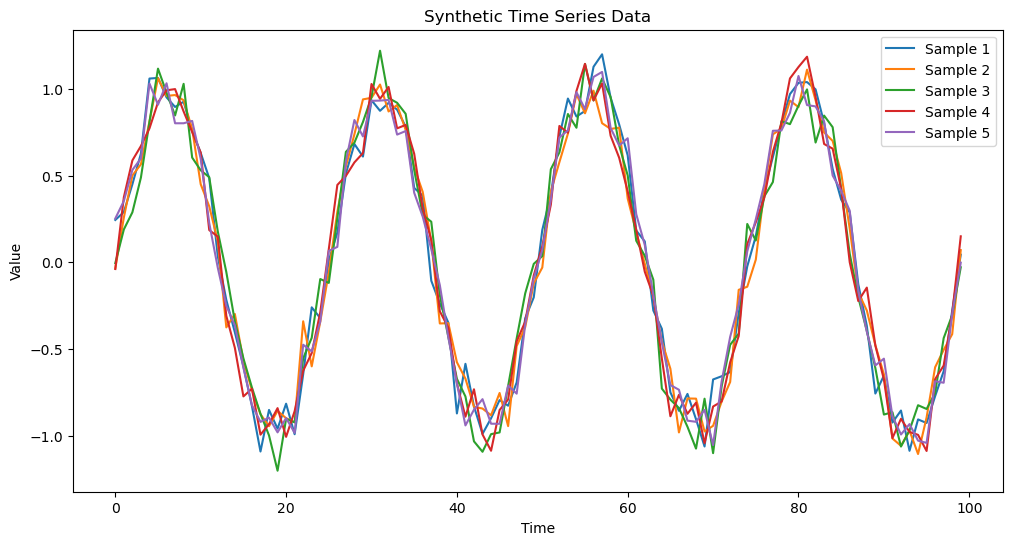

In [212]:
# Generate synthetic time series data
def generate_synthetic_data(num_samples, seq_length, num_features):
    data = []
    for _ in range(num_samples):
        time_series = []
        for _ in range(num_features):
            # Generate a sine wave with some noise
            t = np.linspace(0, 8*np.pi, seq_length)
            signal = np.sin(t) + 0.1 * np.random.randn(seq_length)
            time_series.append(signal)
        time_series = np.stack(time_series, axis=-1)  # Shape: [seq_length, num_features]
        data.append(time_series)
    return np.array(data)

# Parameters for synthetic data
num_samples = 1000
seq_length = 100
num_features = 2

# Generate synthetic dataset
synthetic_data = generate_synthetic_data(num_samples, seq_length, num_features)

# Convert to PyTorch tensor
synthetic_data_tensor = torch.tensor(synthetic_data, dtype=torch.float32)

# Plot a few samples
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(synthetic_data_tensor[i, :, 0], label=f'Sample {i+1}')
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [226]:
# Model parameters
d_model = 128
nhead = 4
num_encoder_layers = 3
dim_feedforward = 512
dropout = 0.1

# Create the Transformer noise model
transformer_model = TransformerNoiseModel(num_features, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Create the diffusion model with the transformer
diffusion_model = DiffusionModelTransformer(transformer_model)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

diffusion_model.model.apply(init_weights)

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion_model.model.to(device)

# Sample synthetic data shape
x_shape = (1, seq_length, num_features)  # Example for generating 1 sample

In [ ]:
# Training parameters
learning_rate = 1e-5
num_epochs = 20
batch_size = 32

# Loss function and optimizer
optimizer = torch.optim.Adam(diffusion_model.model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Create DataLoader
train_loader = torch.utils.data.DataLoader(synthetic_data_tensor, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        batch = batch.to(device)
        
        # Forward diffusion
        x_t, t, noise = diffusion_model.forward_diffusion(batch)
        
        # Reverse diffusion (predict noise)
        pred_noise = diffusion_model.model(x_t, t.unsqueeze(1).repeat(1,seq_length).unsqueeze(-1))

        # Compute loss
        loss = criterion(pred_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(diffusion_model.model.parameters(), max_norm=1.0)
        
        
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

Epoch 1/20, Loss: 0.9738
Epoch 2/20, Loss: 1.0429
Epoch 3/20, Loss: 1.0670
Epoch 4/20, Loss: 0.9720
Epoch 5/20, Loss: 1.0144
Epoch 6/20, Loss: 1.0382
Epoch 7/20, Loss: 0.9438


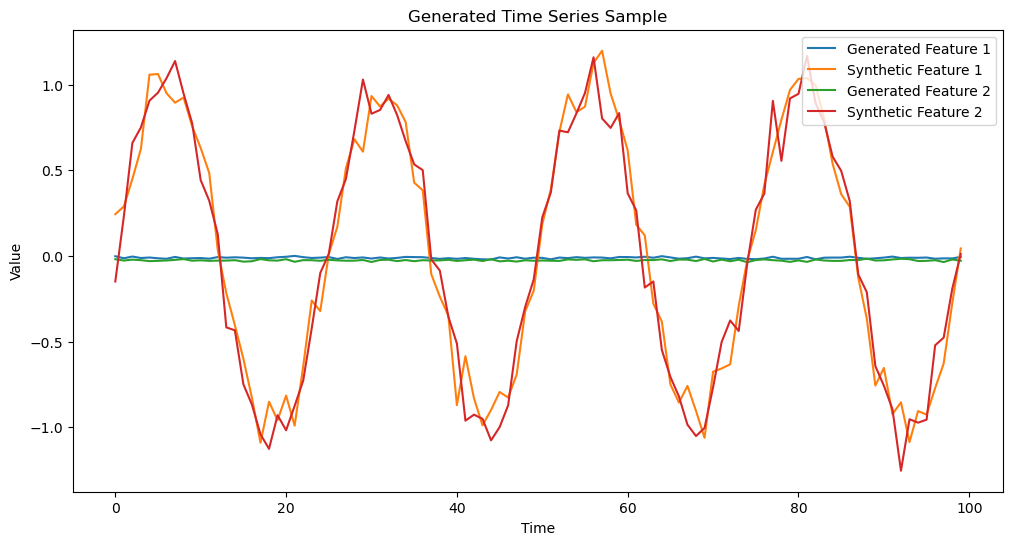

In [225]:
# Generate new samples
generated_samples = diffusion_model.p_sample_loop(x_shape, device)

# Move generated samples back to CPU and detach from the computation graph
generated_samples = generated_samples.squeeze(0).cpu().detach().numpy()

# Plot the generated sample
plt.figure(figsize=(12, 6))
for i in range(num_features):
    plt.plot(generated_samples[:, i], label=f'Generated Feature {i+1}')
    plt.plot(synthetic_data_tensor[0, :, i], label=f'Synthetic Feature {i+1}')
plt.title('Generated Time Series Sample')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()